In [3]:
from numpy import *
import numpy as np
# import matplotlib.pyplot as plt
import padasip as pa 
import scipy.io as sio 
#from scipy import optimize as op
from cvxopt  import solvers, matrix
import random
#import os

In [4]:
hat='/Users/minyifan/Downloads/digits4000.mat'
data = sio.loadmat(hat)

In [4]:
hat='/Users/minyifan/Downloads/PA-1-data-matlab/count_data.mat'
data = sio.loadmat(hat)
trainx=data['trainx']
trainy=data['trainy']
testx=data['testx']
testy=data['testy']

In [20]:
data['trainset'][1]

array([2001, 2002, 2003, ..., 3998, 3999, 4000], dtype=uint16)

In [42]:
def getphy(x,n): #calculating the phy in different dimention
    k=np.mat(ones((size(x),1)))
    for i in range(1,n+1):
        k=np.column_stack((k,np.power(x,i)))
    return k.T

def LS(phy,y):
    #phy=getphy(x,n)
    step1=phy*phy.T
    step2=step1.I*phy
    return step2*y

def RLS(phy,y,mu): #mu means regulization parameter in RLS
    #phy=getphy(x,n)
    l,m=phy.shape
    step1=phy*phy.T+mu*np.eye(l)
    step2=step1.I*phy
    return step2*y

def LASSO(phy,y,mu): #mu means regulization parameter in LASSO 
    #phy=getphy(x,n)
    l,m=phy.shape
    s_phy=phy*phy.T
    H1=np.concatenate((s_phy,-1*s_phy),axis=0)
    H2=np.concatenate((-1*s_phy,s_phy),axis=0)
    H=np.concatenate((H1,H2),axis=1)
    F_y=phy*y
    F=mu*np.ones((2*len(F_y),1))-np.concatenate((F_y,-F_y),axis=0)
    G=np.mat(np.eye(2*l))*-1
    O=np.mat(np.zeros((2*l,1)))
    assume=solvers.qp(matrix(H),matrix(F),matrix(G),matrix(O))
    thig=np.mat(assume['x'])
    le=int(len(thig)/2)
    thig=thig[:le]-thig[le:]
    return thig

def prediction(phy,thi):
    a,b=thi.shape
    #phy=getphy(x,a-1)
    return phy.T*thi

def var(x,y):
    x_y=x-y
    return np.power(x_y,2).sum()/len(x)

def RR(phy,y):
    #Bounds=((None,None),)*(n+1)+((0,None),)*len(x)
    #phy=getphy(x,n)
    l,m=phy.shape
    Bounds=((None,None),)*(l)+((0,None),)*m
    #the bounds of thita's and k's
    a1=np.concatenate((phy.T*-1,-1*np.eye(m)),axis=1)
    a2=np.concatenate((phy.T,-1*np.eye(m)),axis=1)
    A=np.concatenate((a1,a2),axis=0)
    f=np.concatenate((np.zeros((l,1)),np.ones((m,1))),axis=0)
    b=np.concatenate((-1*y,y),axis=0)
    #res = op.linprog(f.T[0],A.getA(),b.T[0],bounds=Bounds) 
    ##tried to usee linprog in scipy but did not work
    res=solvers.lp(matrix(f.T[0]),matrix(A.getA()),matrix(b),bounds=Bounds)
    #lp function in cvxopt is much better 
    return np.mat(res['x'][:l])
    
def BR(phy,y,a,aa):#a means the Standard Deviation of estimate
    #phy=getphy(x,n)
    l,m=phy.shape
    step1=phy*phy.T/(a*a)+np.eye(l)/aa
    step2=step1.I*phy*y/(a*a)
    return step2,step1.I

def BR_pre_st(phy,va):
    v=list()
    for i in range(len(phy.T)):
        v.append((phy.T[i]*va*phy.T[i].T)[0][0])
    return np.power(v,0.5)

def sample(samp,percent,n):
    Samp=list()
    for i in range(n):
        Samp.append(random.sample(samp,int(percent*len(samp))))
    return Samp

def sample_xy(samp,percent,n):
    Samp=sample(samp,percent,n)
    sampx=list()
    sampy=list()
    for i in range(n):
        sampx.append(np.array([[x[0] for x in Samp[i]]]))
        sampy.append(np.array([[x[1] for x in Samp[i]]]))
    return sampx,sampy

def count_var(l_sampx,l_sampy,func):
    Var=list()
    for i in range(len(l_sampx)):
        k=func(np.mat(getphy(l_sampx[i].T,5)),np.mat(l_sampy[i].T))
        Var.append(var(polyy,prediction(getphy(np.mat(polyx.T),5),k)))
    return average(Var)
        
def count_var_mu(l_sampx,l_sampy,func,mu):
    Var=list()
    for i in range(len(l_sampx)):
        k=func(np.mat(getphy(l_sampx[i].T,5)),np.mat(l_sampy[i].T),mu)
        Var.append(var(polyy,prediction(getphy(np.mat(polyx.T),5),k)))
    return average(Var)        

In [7]:
th_LS=LS(np.mat(getphy(sampx.T,5)),np.mat(sampy))
th_RLS=RLS(np.mat(getphy(sampx.T,5)),np.mat(sampy),0.5)
th_LASSO=LASSO(np.mat(getphy(sampx.T,5)),np.mat(sampy),1)
th_RR=RR(np.mat(getphy(sampx.T,5)),np.mat(sampy))
th_BR,va=BR(np.mat(getphy(sampx.T,5)),np.mat(sampy),3,1)

     pcost       dcost       gap    pres   dres
 0: -1.0534e+03 -1.0396e+03  2e+01  9e+00  2e-16
 1: -1.0398e+03 -1.0385e+03  2e+00  8e-01  3e-16
 2: -1.0376e+03 -1.0376e+03  1e-01  4e-02  1e-16
 3: -1.0375e+03 -1.0375e+03  6e-03  3e-16  3e-16
 4: -1.0375e+03 -1.0375e+03  3e-04  2e-16  3e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  3e+02  9e-01  1e-15  1e+00
 1:  3.9223e+01  3.9399e+01  6e+01  2e-01  8e-16  4e-01
 2:  5.8134e+01  5.8186e+01  1e+01  4e-02  2e-14  1e-01
 3:  6.3314e+01  6.3326e+01  2e+00  7e-03  2e-13  2e-02
 4:  6.4289e+01  6.4291e+01  4e-01  1e-03  7e-14  3e-03
 5:  6.4452e+01  6.4452e+01  7e-02  2e-04  3e-14  6e-04
 6:  6.4483e+01  6.4483e+01  3e-03  8e-06  8e-14  2e-05
 7:  6.4484e+01  6.4484e+01  3e-05  8e-08  3e-13  2e-07
Optimal solution found.


In [43]:
kk=np.arange(-2,2,0.01)
kk=np.mat(kk).T
kk=kk.getA()

In [45]:
l=BR_pre_st(np.mat(getphy(np.mat(kk),5)),va)
g=list()
for i in range(len(l)):
    g.append(l[i][0].tolist())

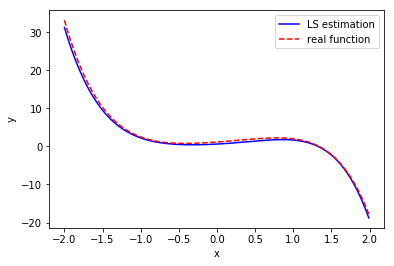

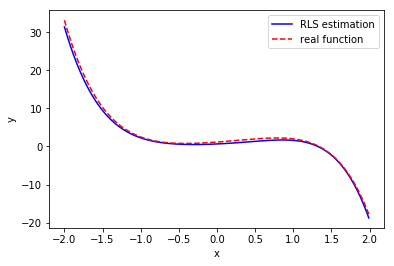

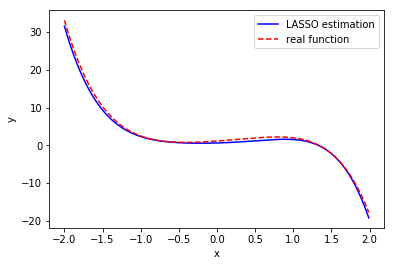

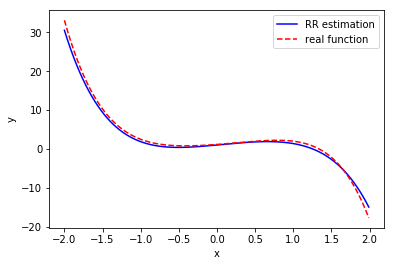

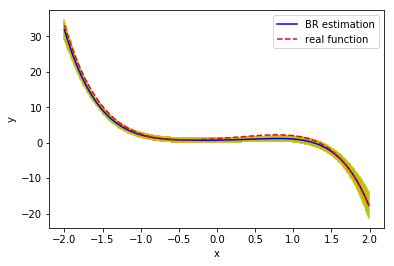

In [18]:
plt.figure()
#plt.subplot(2,3,1)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS),'b',label='LS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("/Users/minyifan/Desktop/plt2.png")

#plt.subplot(2,3,2)
plt.figure()
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_RLS),'b',label='RLS estimation')
#plt.plot(np.mat(kk),prediction(kk,t))
#plt.plot(sampx.T,sampy,"ro")
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("/Users/minyifan/Desktop/plt3.png")
#plt.subplot(2,3,3)

plt.figure()
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LASSO),'b',label='LASSO estimation')
#plt.plot(np.mat(kk),prediction(kk,t))
#plt.plot(sampx.T,sampy,"ro")
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("/Users/minyifan/Desktop/plt4.png")

plt.figure()
#plt.subplot(2,2,3)
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_RR),'b',label='RR estimation')
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("/Users/minyifan/Desktop/plt5.png")

plt.figure()
#plt.subplot(2,2,4)
#plt.plot(np.mat(kk),prediction(kk,t))
#plt.plot(sampx.T,sampy,"ro")
#plt.plot(np.mat(kk),g)
#plt.bar(np.mat(kk).getA().T[0],g.T[0])
for i in range(len(kk)):
    plt.plot((kk[i][0],kk[i][0]),((prediction(getphy(np.mat(kk[i]),5),th_BR).getA()+g[i])[0][0],(prediction(getphy(np.mat(kk[i]),5),th_BR).getA()-g[i])[0][0]),'y')
#plt.stackplot(kk.T[0],prediction(getphy(np.mat(kk),5),th_BR).getA().T[0],g.T[0])
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_BR),'b',label='BR estimation')
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("/Users/minyifan/Desktop/plt6.png")

In [16]:
kk.getA()[i][0]

-2.0

In [370]:
#th_RLS=RLS(np.mat(getphy(sampx.T,5)),np.mat(sampy),0.5)
#th_LASSO=LASSO(np.mat(getphy(sampx.T,5)),np.mat(sampy),1)
var(polyy,prediction(getphy(np.mat(polyx.T),5),th_LS))

0.40864388356985359

In [371]:
var(polyy,prediction(getphy(np.mat(polyx.T),5),th_RLS))

0.40760022370428389

In [372]:
var(polyy,prediction(getphy(np.mat(polyx.T),5),th_LASSO))

0.47460685881918768

In [375]:
var(polyy,prediction(getphy(np.mat(polyx.T),5),th_RR))

0.76804615051335634

In [374]:
var(polyy,prediction(getphy(np.mat(polyx.T),5),th_BR))

0.537227250964461

In [376]:
samp=np.concatenate((sampx.T,sampy),axis=1)

In [394]:
x,y=sample_xy(samp.tolist(),0.75,1)
x_75=x[0]
y_75=y[0]
x,y=sample_xy(samp.tolist(),0.5,1)
x_50=x[0]
y_50=y[0]
x,y=sample_xy(samp.tolist(),0.25,1)
x_25=x[0]
y_25=y[0]
x,y=sample_xy(samp.tolist(),0.1,1)
x_10=x[0]
y_10=y[0]

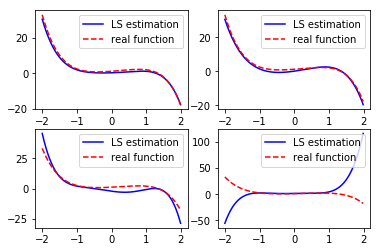

In [400]:
th_LS_75=LS(np.mat(getphy(x_75.T,5)),np.mat(y_75.T))
th_LS_50=LS(np.mat(getphy(x_50.T,5)),np.mat(y_50.T))
th_LS_25=LS(np.mat(getphy(x_25.T,5)),np.mat(y_25.T))
th_LS_10=LS(np.mat(getphy(x_10.T,5)),np.mat(y_10.T))
plt.figure()
plt.subplot(2,2,1)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_75),'b',label='LS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,2)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_50),'b',label='LS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,3)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_25),'b',label='LS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,4)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_10),'b',label='LS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.savefig("/Users/minyifan/Desktop/plt_LS.png")

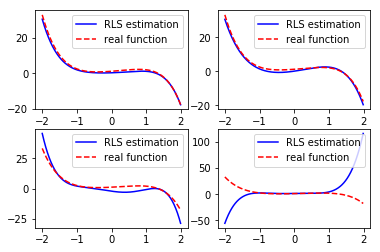

In [401]:
th_RLS_75=RLS(np.mat(getphy(x_75.T,5)),np.mat(y_75.T),0.5)
th_RLS_50=RLS(np.mat(getphy(x_50.T,5)),np.mat(y_50.T),0.5)
th_RLS_25=RLS(np.mat(getphy(x_25.T,5)),np.mat(y_25.T),0.5)
th_RLS_10=RLS(np.mat(getphy(x_10.T,5)),np.mat(y_10.T),0.5)
plt.figure()
plt.subplot(2,2,1)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_75),'b',label='RLS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,2)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_50),'b',label='RLS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,3)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_25),'b',label='RLS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,4)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_10),'b',label='RLS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.savefig("/Users/minyifan/Desktop/plt_RLS.png")

     pcost       dcost       gap    pres   dres
 0: -7.7656e+02 -7.6346e+02  2e+01  9e+00  8e-17
 1: -7.6386e+02 -7.6269e+02  2e+00  8e-01  1e-16
 2: -7.6194e+02 -7.6192e+02  2e-01  6e-02  6e-17
 3: -7.6180e+02 -7.6180e+02  9e-03  2e-03  2e-16
 4: -7.6180e+02 -7.6180e+02  9e-05  2e-05  2e-16
 5: -7.6180e+02 -7.6180e+02  9e-07  2e-07  1e-16
 6: -7.6180e+02 -7.6180e+02  9e-09  2e-09  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.8346e+02 -6.6734e+02  2e+01  1e+01  8e-17
 1: -6.6804e+02 -6.6667e+02  2e+00  9e-01  3e-16
 2: -6.6610e+02 -6.6598e+02  2e-01  1e-01  2e-16
 3: -6.6582e+02 -6.6582e+02  4e-03  8e-04  2e-16
 4: -6.6582e+02 -6.6582e+02  4e-05  8e-06  9e-17
 5: -6.6582e+02 -6.6582e+02  4e-07  8e-08  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.4567e+02 -3.3152e+02  2e+01  9e+00  2e-16
 1: -3.3219e+02 -3.3073e+02  2e+00  1e+00  3e-16
 2: -3.3011e+02 -3.3005e+02  2e-01  7e-02  1e-16
 3: -3.2995e+02 -3.2996e

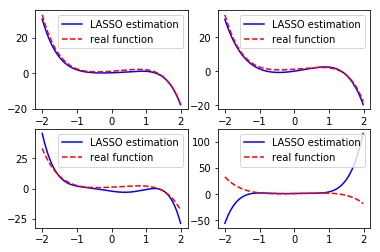

In [402]:
th_LASSO_75=LASSO(np.mat(getphy(x_75.T,5)),np.mat(y_75.T),1)
th_LASSO_50=LASSO(np.mat(getphy(x_50.T,5)),np.mat(y_50.T),1)
th_LASSO_25=LASSO(np.mat(getphy(x_25.T,5)),np.mat(y_25.T),1)
th_LASSO_10=LASSO(np.mat(getphy(x_10.T,5)),np.mat(y_10.T),1)
plt.figure()
plt.subplot(2,2,1)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_75),'b',label='LASSO estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,2)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_50),'b',label='LASSO estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,3)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_25),'b',label='LASSO estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,4)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_10),'b',label='LASSO estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.savefig("/Users/minyifan/Desktop/plt_LASSO.png")

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+02  9e-01  9e-16  1e+00
 1:  2.3884e+01  2.4035e+01  4e+01  2e-01  9e-16  3e-01
 2:  3.6284e+01  3.6333e+01  1e+01  4e-02  2e-14  1e-01
 3:  4.0609e+01  4.0617e+01  1e+00  6e-03  6e-14  1e-02
 4:  4.1068e+01  4.1071e+01  4e-01  2e-03  6e-13  5e-03
 5:  4.1210e+01  4.1211e+01  1e-01  5e-04  1e-12  2e-03
 6:  4.1254e+01  4.1254e+01  2e-02  7e-05  4e-13  2e-04
 7:  4.1261e+01  4.1261e+01  2e-04  8e-07  8e-14  2e-06
 8:  4.1261e+01  4.1261e+01  2e-06  8e-09  2e-13  2e-08
Optimal solution found.


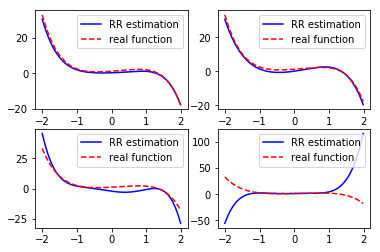

In [406]:
th_RR_75=RR(np.mat(getphy(x_75.T,5)),np.mat(y_75.T))
th_RR_50=LS(np.mat(getphy(x_50.T,5)),np.mat(y_50.T))
th_RR_25=LS(np.mat(getphy(x_25.T,5)),np.mat(y_25.T))
th_RR_10=LS(np.mat(getphy(x_10.T,5)),np.mat(y_10.T))
plt.figure()
plt.subplot(2,2,1)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_75),'b',label='RR estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,2)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_50),'b',label='RR estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")

plt.subplot(2,2,3)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_25),'b',label='RR estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
#plt.xlabel("x")
#plt.ylabel("y")
plt.subplot(2,2,4)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS_10),'b',label='RR estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')

plt.savefig("/Users/minyifan/Desktop/plt_RR.png")

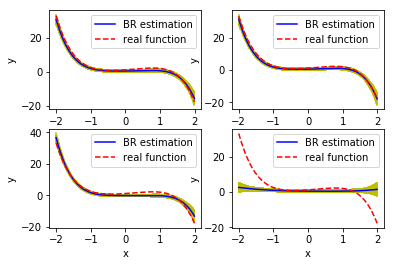

In [418]:
th_BR,va=BR(np.mat(getphy(x_75.T,5)),np.mat(y_75.T),3,1)
plt.figure()
plt.subplot(2,2,1)
for i in range(len(kk)):
    plt.plot((kk[i][0],kk[i][0]),((prediction(getphy(np.mat(kk[i]),5),th_BR).getA()+g[i])[0][0],(prediction(getphy(np.mat(kk[i]),5),th_BR).getA()-g[i])[0][0]),'y')
#plt.stackplot(kk.T[0],prediction(getphy(np.mat(kk),5),th_BR).getA().T[0],g.T[0])
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_BR),'b',label='BR estimation')
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
th_BR,va=BR(np.mat(getphy(x_50.T,5)),np.mat(y_50.T),3,1)
plt.subplot(2,2,2)
for i in range(len(kk)):
    plt.plot((kk[i][0],kk[i][0]),((prediction(getphy(np.mat(kk[i]),5),th_BR).getA()+g[i])[0][0],(prediction(getphy(np.mat(kk[i]),5),th_BR).getA()-g[i])[0][0]),'y')
#plt.stackplot(kk.T[0],prediction(getphy(np.mat(kk),5),th_BR).getA().T[0],g.T[0])
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_BR),'b',label='BR estimation')
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
th_BR,va=BR(np.mat(getphy(x_25.T,5)),np.mat(y_25.T),3,1)
plt.subplot(2,2,3)
for i in range(len(kk)):
    plt.plot((kk[i][0],kk[i][0]),((prediction(getphy(np.mat(kk[i]),5),th_BR).getA()+g[i])[0][0],(prediction(getphy(np.mat(kk[i]),5),th_BR).getA()-g[i])[0][0]),'y')
#plt.stackplot(kk.T[0],prediction(getphy(np.mat(kk),5),th_BR).getA().T[0],g.T[0])
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_BR),'b',label='BR estimation')
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
th_BR,va=BR(np.mat(getphy(x_10.T,5)),np.mat(y_10.T),3,1)
plt.subplot(2,2,4)
for i in range(len(kk)):
    plt.plot((kk[i][0],kk[i][0]),((prediction(getphy(np.mat(kk[i]),5),th_BR).getA()+g[i])[0][0],(prediction(getphy(np.mat(kk[i]),5),th_BR).getA()-g[i])[0][0]),'y')
#plt.stackplot(kk.T[0],prediction(getphy(np.mat(kk),5),th_BR).getA().T[0],g.T[0])
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_BR),'b',label='BR estimation')
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("/Users/minyifan/Desktop/plt_BR.png")

In [1]:
v_LS=list()
v_RLS=list()
v_LASSO=list()
v_RR=list()
v_BR=list()
#for i in np.arange(0.25,1,0.05): 
   # x,y=sample_xy(samp.tolist(),i,500)
   # v_LS.append(count_var(x,y,LS))
   # v_LASSO.append(count_var_mu(x,y,LASSO,1))
    #v_RLS.append(count_var_mu(x,y,RLS,1))
   # v_RR.append(count_var(x,y,RR))

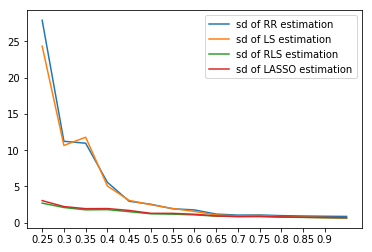

In [433]:
fig=plt.figure("sd of RR")
axes=fig.add_subplot(1,1,1)
plt.plot(np.power(np.array(v_RR),0.5),label='sd of RR estimation')
plt.plot(np.power(np.array(v_LS),0.5),label='sd of LS estimation')
plt.plot(np.power(np.array(v_RLS),0.5),label='sd of RLS estimation')
plt.plot(np.power(np.array(v_LASSO),0.5),label='sd of LASSO estimation')
plt.legend(loc='upper right')
plt.xticks(np.arange(0,14),np.arange(0.25,1,0.05))
#axes.set_xticks(np.arange(0.25,1,0.05))
plt.savefig("/Users/minyifan/Desktop/plt_SD.png")

In [448]:
th_LASSO.T

matrix([[  6.85546608e-01,   5.97286528e-01,   1.61464970e+00,
          -1.00905169e+00,  -5.32147643e-05,  -6.73910060e-06,
          -1.20104698e+00,  -1.37937860e-01,   8.37884444e-01,
          -1.64979139e-02,  -1.44624448e-01]])

     pcost       dcost       gap    pres   dres
 0: -1.0720e+03 -1.0201e+03  9e+01  1e+01  1e-04
 1: -1.0330e+03 -1.0447e+03  1e+01  1e-15  9e-15
 2: -1.0416e+03 -1.0428e+03  1e+00  1e-15  3e-15
 3: -1.0419e+03 -1.0422e+03  2e-01  2e-16  1e-15
 4: -1.0420e+03 -1.0421e+03  3e-02  5e-16  1e-15
 5: -1.0421e+03 -1.0421e+03  3e-04  6e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  3e+02  8e-01  1e-14  1e+00
 1:  3.7380e+01  3.7498e+01  5e+01  2e-01  3e-12  3e-01
 2:  5.2374e+01  5.2407e+01  1e+01  3e-02  7e-11  8e-02
 3:  5.6178e+01  5.6185e+01  2e+00  6e-03  2e-10  2e-02
 4:  5.6860e+01  5.6862e+01  4e-01  1e-03  5e-11  3e-03
 5:  5.6989e+01  5.6990e+01  9e-02  3e-04  4e-10  7e-04
 6:  5.7021e+01  5.7021e+01  9e-03  3e-05  2e-09  7e-05
 7:  5.7025e+01  5.7025e+01  1e-04  4e-07  2e-10  1e-06
 8:  5.7025e+01  5.7025e+01  1e-06  4e-09  5e-10  1e-08
Optimal solution found.


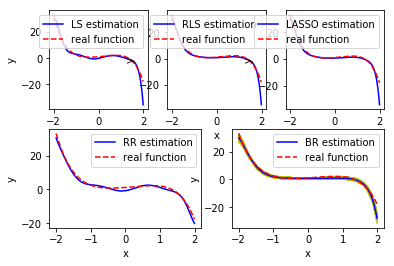

In [445]:
th_LS=LS(np.mat(getphy(sampx.T,10)),np.mat(sampy))
th_RLS=RLS(np.mat(getphy(sampx.T,10)),np.mat(sampy),1)
th_LASSO=LASSO(np.mat(getphy(sampx.T,10)),np.mat(sampy),1)
th_RR=RR(np.mat(getphy(sampx.T,10)),np.mat(sampy))
th_BR,va=BR(np.mat(getphy(sampx.T,10)),np.mat(sampy),3,1)
plt.figure()
plt.subplot(2,3,1)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),10),th_LS),'b',label='LS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig("/Users/minyifan/Desktop/plt6.png")

plt.subplot(2,3,2)
#plt.figure()
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),10),th_RLS),'b',label='RLS estimation')
#plt.plot(np.mat(kk),prediction(kk,t))
#plt.plot(sampx.T,sampy,"ro")
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig("/Users/minyifan/Desktop/plt7.png")
plt.subplot(2,3,3)

#plt.figure()
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),10),th_LASSO),'b',label='LASSO estimation')
#plt.plot(np.mat(kk),prediction(kk,t))
#plt.plot(sampx.T,sampy,"ro")
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig("/Users/minyifan/Desktop/plt8.png")

#plt.figure()
plt.subplot(2,2,3)
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),10),th_RR),'b',label='RR estimation')
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig("/Users/minyifan/Desktop/plt9.png")

#plt.figure()
plt.subplot(2,2,4)
#plt.plot(np.mat(kk),prediction(kk,t))
#plt.plot(sampx.T,sampy,"ro")
#plt.plot(np.mat(kk),g)
#plt.bar(np.mat(kk).getA().T[0],g.T[0])
for i in range(len(kk)):
    plt.plot((kk[i][0],kk[i][0]),((prediction(getphy(np.mat(kk[i]),10),th_BR).getA()+g[i])[0][0],(prediction(getphy(np.mat(kk[i]),10),th_BR).getA()-g[i])[0][0]),'y')
#plt.stackplot(kk.T[0],prediction(getphy(np.mat(kk),5),th_BR).getA().T[0],g.T[0])
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),10),th_BR),'b',label='BR estimation')
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("/Users/minyifan/Desktop/plt11.png")

     pcost       dcost       gap    pres   dres
 0: -1.0410e+03 -9.9590e+02  8e+01  1e+01  5e-06
 1: -1.0115e+03 -1.0224e+03  1e+01  1e-15  9e-10
 2: -1.0200e+03 -1.0213e+03  1e+00  8e-16  1e-09
 3: -1.0205e+03 -1.0206e+03  1e-01  6e-16  8e-11
 4: -1.0206e+03 -1.0206e+03  1e-02  1e-15  2e-11
 5: -1.0206e+03 -1.0206e+03  1e-04  1e-15  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  3e+02  1e+00  6e-16  1e+00
 1:  4.1830e+01  4.2034e+01  6e+01  2e-01  6e-08  4e-01
 2:  6.0816e+01  6.0869e+01  1e+01  4e-02  1e-07  9e-02
 3:  6.5849e+01  6.5864e+01  3e+00  1e-02  7e-06  2e-02
 4:  6.7382e+01  6.7384e+01  4e-01  1e-03  1e-06  3e-03
 5:  6.7535e+01  6.7535e+01  1e-01  3e-04  4e-07  9e-04
 6:  6.7577e+01  6.7577e+01  2e-02  5e-05  5e-06  1e-04
 7:  6.7584e+01  6.7584e+01  2e-03  5e-06  7e-07  2e-05
 8:  6.7585e+01  6.7585e+01  2e-05  5e-08  4e-04  2e-07
 9:  6.7585e+01  6.7451e+01  1e-06  2e-09  4e-01  1e-08
10:  6.7585e+01  6.7

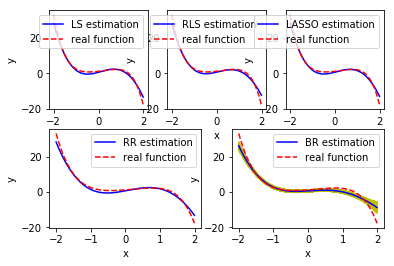

In [53]:
th_LS=LS(np.mat(getphy(sampX,5)),np.mat(sampy))
th_RLS=RLS(np.mat(getphy(sampX,5)),np.mat(sampy),1)
th_LASSO=LASSO(np.mat(getphy(sampx.T,5)),np.mat(sampy),1)
th_RR=RR(np.mat(getphy(sampX,5)),np.mat(sampy))
th_BR,va=BR(np.mat(getphy(sampX,5)),np.mat(sampy),3,1)
plt.figure()
plt.subplot(2,3,1)
l1,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LS),'b',label='LS estimation')
#plt.plot(sampx.T,sampy,"ro")
l2,=plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig("/Users/minyifan/Desktop/plt6.png")

plt.subplot(2,3,2)
#plt.figure()
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_RLS),'b',label='RLS estimation')
#plt.plot(np.mat(kk),prediction(kk,t))
#plt.plot(sampx.T,sampy,"ro")
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig("/Users/minyifan/Desktop/plt7.png")
plt.subplot(2,3,3)

#plt.figure()
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_LASSO),'b',label='LASSO estimation')
#plt.plot(np.mat(kk),prediction(kk,t))
#plt.plot(sampx.T,sampy,"ro")
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig("/Users/minyifan/Desktop/plt8.png")

#plt.figure()
plt.subplot(2,2,3)
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_RR),'b',label='RR estimation')
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig("/Users/minyifan/Desktop/plt9.png")

#plt.figure()
plt.subplot(2,2,4)
#plt.plot(np.mat(kk),prediction(kk,t))
#plt.plot(sampx.T,sampy,"ro")
#plt.plot(np.mat(kk),g)
#plt.bar(np.mat(kk).getA().T[0],g.T[0])
for i in range(len(kk)):
    plt.plot((kk[i][0],kk[i][0]),((prediction(getphy(np.mat(kk[i]),5),th_BR).getA()+g[i])[0][0],(prediction(getphy(np.mat(kk[i]),5),th_BR).getA()-g[i])[0][0]),'y')
#plt.stackplot(kk.T[0],prediction(getphy(np.mat(kk),5),th_BR).getA().T[0],g.T[0])
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),th_BR),'b',label='BR estimation')
plt.plot(np.mat(kk),prediction(getphy(np.mat(kk),5),np.mat(thtrue)),'r--',label='real function')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("/Users/minyifan/Desktop/plt12.png")

2.4465437208147893

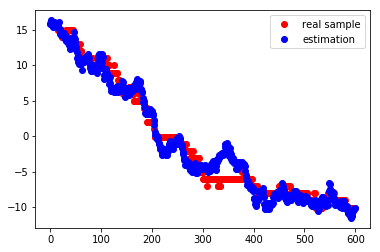

In [124]:
k_RLS=RLS(np.mat(Trainx),np.mat(trainy),0.85)
V_RLS=var(prediction(np.mat(Testx),k_RLS),testy)
x=np.arange(len(testy))
plt.plot(x,testy.T[0],'ro',label='real sample')
plt.plot(x,prediction(np.mat(Testx),k_RLS).getA().T[0],'bo',label='estimation')
plt.legend(loc='upper right')
plt.savefig('/Users/minyifan/Desktop/plt12.png')
V_RLS

3.1028380141339302

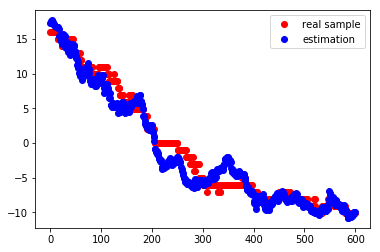

In [101]:
k_LS=LS(np.mat(trainx),np.mat(trainy))
V_LS=var(prediction(np.mat(testx),k_LS),testy)
x=np.arange(len(testy))
plt.plot(x,testy.T[0],'ro',label='real sample')
plt.plot(x,prediction(np.mat(testx),k_LS).getA().T[0],'bo',label='estimation')
plt.legend(loc='upper right')
plt.savefig('/Users/minyifan/Desktop/plt13.png')
V_LS

     pcost       dcost       gap    pres   dres
 0: -3.0886e+05 -1.7184e+04  2e+04  6e+02  2e-14
 1: -4.9024e+04 -1.6900e+04  2e+03  6e+01  2e-14
 2: -2.2683e+04 -1.6400e+04  6e+02  1e+01  3e-15
 3: -1.6437e+04 -1.6343e+04  6e+01  3e-01  5e-16
 4: -1.6334e+04 -1.6329e+04  6e+00  2e-02  2e-16
 5: -1.6326e+04 -1.6326e+04  5e-01  1e-03  2e-16
 6: -1.6326e+04 -1.6326e+04  2e-02  2e-05  2e-16
 7: -1.6326e+04 -1.6326e+04  1e-03  1e-07  1e-16
 8: -1.6326e+04 -1.6326e+04  3e-05  1e-09  1e-16
Optimal solution found.


2.3193890009756526

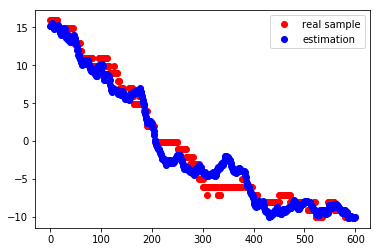

In [125]:
k_LASSO=LASSO(np.mat(Trainx),np.mat(trainy),90)
V_LASSO=var(prediction(np.mat(Testx),k_LASSO),testy)
x=np.arange(len(testy))
plt.plot(x,testy.T[0],'ro',label='real sample')
plt.plot(x,prediction(np.mat(Testx),k_LASSO).getA().T[0],'bo',label='estimation')
plt.legend(loc='upper right')
plt.savefig('/Users/minyifan/Desktop/plt14.png')
V_LASSO

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.1316e-14  2e+03  6e-01  9e-16  1e+00
 1:  1.7856e+02  1.7869e+02  4e+02  1e-01  2e-15  3e-01
 2:  3.3102e+02  3.3105e+02  9e+01  2e-02  9e-15  8e-02
 3:  3.6933e+02  3.6934e+02  2e+01  6e-03  2e-14  2e-02
 4:  3.7769e+02  3.7769e+02  6e+00  2e-03  7e-14  6e-03
 5:  3.7998e+02  3.7998e+02  2e+00  4e-04  2e-13  2e-03
 6:  3.8069e+02  3.8069e+02  3e-01  8e-05  8e-14  3e-04
 7:  3.8080e+02  3.8080e+02  6e-02  2e-05  8e-14  6e-05
 8:  3.8083e+02  3.8083e+02  1e-02  3e-06  4e-12  2e-05
 9:  3.8083e+02  3.8083e+02  2e-04  6e-08  2e-13  2e-07
Optimal solution found.


3.1189971189628598

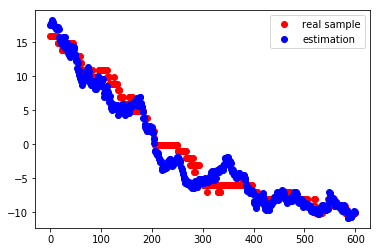

In [103]:
k_RR=RR(np.mat(trainx),np.mat(trainy))
V_RR=var(prediction(np.mat(testx),k_RR),testy)
x=np.arange(len(testy))
plt.plot(x,testy.T[0],'ro',label='real sample')
plt.plot(x,prediction(np.mat(testx),k_RR).getA().T[0],'bo',label='estimation')
plt.legend(loc='upper right')
plt.savefig('/Users/minyifan/Desktop/plt15.png')
V_RR

2.6503715010377134

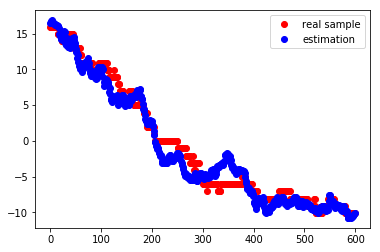

In [104]:
k_BR,va=BR(np.mat(trainx),np.mat(trainy),1,2)
V_BR=var(prediction(np.mat(testx),k_BR),testy)
x=np.arange(len(testy))
plt.plot(x,testy.T[0],'ro',label='real sample')
plt.plot(x,prediction(np.mat(testx),k_BR).getA().T[0],'bo',label='estimation')
plt.legend(loc='upper right')
plt.savefig('/Users/minyifan/Desktop/plt16.png')
V_BR

In [243]:
v_RR

3.1189971189628598

In [110]:
pow_trainx=np.column_stack((np.mat(trainx.T),np.power(np.mat(trainx.T),2))).T
pow_testx=np.column_stack((np.mat(testx.T),np.power(np.mat(testx.T),2))).T

In [128]:
k_LASSO=LASSO(np.mat(pow_trainx),np.mat(trainy),30)
V_LASSO=var(prediction(np.mat(pow_testx),k_LASSO),testy)
V_LASSO

     pcost       dcost       gap    pres   dres
 0: -4.9656e+04 -1.7184e+04  7e+03  2e+02  7e-15
 1: -1.9592e+04 -1.7052e+04  7e+02  2e+01  7e-15
 2: -1.7229e+04 -1.6920e+04  1e+02  2e+00  9e-16
 3: -1.6912e+04 -1.6896e+04  2e+01  2e-01  1e-16
 4: -1.6889e+04 -1.6889e+04  2e+00  8e-03  1e-16
 5: -1.6888e+04 -1.6889e+04  1e-01  9e-05  1e-16
 6: -1.6888e+04 -1.6888e+04  5e-03  1e-06  1e-16
 7: -1.6888e+04 -1.6888e+04  2e-04  2e-08  8e-17
Optimal solution found.


2.2051384864227841

In [134]:
k_RLS=RLS(np.mat(pow_trainx),np.mat(trainy),0.85)
V_RLS=var(prediction(np.mat(pow_testx),k_RLS),testy)
V_RLS

2.4465437208147893

In [123]:
Trainx=np.column_stack((trainx.T,np.power(trainx.T,2))).T
Testx=np.column_stack((testx.T,np.power(testx.T,2))).T